In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions
import six

2022-12-20 10:24:51.679749: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
A = 2*tfd.Uniform().sample(1000)
X = tfd.InverseGamma(concentration =1.5, scale = 0.6 ).sample(1000)
R1 = A*X

train_dataset = R1[:250]
train_dataset = tf.reshape(train_dataset,[250,1])
eval_dataset = R1[250:]
eval_dataset=tf.reshape(eval_dataset,[750,1])

In [166]:
class MetricWrapper(tfk.metrics.Mean):
    def __init__(self, fn, name=None, dtype=None, **kwargs):
        super(MetricWrapper, self).__init__(name=name)
        self._fn = fn
        self._fn_kwargs = kwargs
    def update_state(self, y_true, y_pred, sample_weight=None):
        matches = self._fn(y_true, y_pred, **self._fn_kwargs)
        return super(MetricWrapper, self).update_state(
        matches, sample_weight=sample_weight)
    def get_config(self):
        config = {}
        for k, v in six.iteritems(self._fn_kwargs):
            config[k] = K.eval(v) if is_tensor_or_variable(v) else v
        base_config = super(MetricWrapper, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [50]:
class ZerosConstraint(tfk.constraints.Constraint):
    def __init__(self, ref_value):
        self.ref_value = ref_value

    def __call__(self, w):
        return 0*w

    def get_config(self):
        return {'ref_value': self.ref_value}


In [ ]:
def make_mvn_prior(ndim, trainable=False):
        if trainable:
            loc = tf.Variable(tf.random.normal([ndim], stddev=0.1, dtype=tf.float32), name='prior_loc')
            scale = tfp.util.TransformedVariable(
            tf.random.normal([ndim], mean=1.0, stddev=0.1, dtype=tf.float32),
            bijector=tfb.Chain([tfb.Shift(1e-5), tfb.Softplus(), tfb.Shift(0.5413)]), name='prior_scale')
        else:
            loc = tf.zeros(ndim)
            scale = 1
        prior = tfd.Independent(tfd.Normal(loc=loc, scale=scale), reinterpreted_batch_ndims=1)
    return prior

In [254]:
class U_Encoder(tfk.Model):    
    def __init__(self):      
        super(U_Encoder,self).__init__()
        self.alpha_layer  = tfkl.Dense(1, bias_initializer=tfk.initializers.Constant(2))
        self.dense1       = tfkl.Dense(5, activation ='relu',kernel_initializer =tfk.initializers.RandomUniform(minval=0.01, maxval=0.02))
        self.dense2       = tfkl.Dense(5, activation ='relu',kernel_initializer =tfk.initializers.RandomUniform(minval=0.01, maxval=0.02))
        self.dense3       = tfkl.Dense(2, activation='relu',bias_initializer = tfk.initializers.RandomUniform(minval=1, maxval=2))
        self.lambda1      = tfkl.Lambda(lambda x: tf.abs(x)+0.001)
        self.dist_lambda1 = tfpl.DistributionLambda(
                            make_distribution_fn=lambda t: tfd.InverseGamma(
                                concentration=t[...,0], scale=t[...,1]))  
        self.dist_lambda2 = tfpl.DistributionLambda(
                            make_distribution_fn=lambda t: tfd.Gamma(
                                concentration=t[...,0], rate=1))  
        self.dist_lambda3 = tfpl.DistributionLambda(
                            make_distribution_fn=lambda t: tfd.Gamma(
                                concentration=t[...,0], rate=t[...,1]))  
        self.concat1 = tfkl.Concatenate()
        #self.KL_Loss      = tfpl.KLDivergenceAddLoss()
        
## passer prior en gamma et voir ensuite
    def precall(self,inputs):
        x      = self.dense1(inputs)
        x      = self.dense2(x)
        x      = self.dense3(x)
        param  = self.lambda1(x)
        return param        
        
    def call(self, inputs):
        x = self.precall(inputs)
        alpha = self.alpha_layer(0*inputs)
        prior = tfd.InverseGamma(concentration=alpha, scale=1)
        return tfpl.DistributionLambda(
                            make_distribution_fn=lambda t: 
            tfd.InverseGamma(
                                concentration=t[...,0], scale=t[...,1]),
            activity_regularizer = tfpl.KLDivergenceRegularizer(prior))(x)
    
    def call2(self,inputs):
        param = self.precall(inputs)
        alpha  = self.alpha_layer(0*inputs)
        #params = self.concat1([alpha,param])
        return self.dist_lambda2(alpha)
    
    def call3(self,inputs):
        param = self.precall(inputs)
        return self.dist_lambda3(param)
    
    

    
class U_Decoder(tfk.Model):
    def __init__(self):
        super(U_Decoder,self).__init__()
        
        self.dense1  = tfkl.Dense(5, use_bias=True, activation='relu')
        self.dense2  = tfkl.Dense(5, use_bias=True, activation='relu')
        self.dense31 = tfkl.Dense(1, use_bias=True)
        self.dense32 = tfkl.Dense(1, use_bias=True)
        self.lambda1 = tfkl.Lambda(lambda x: tf.abs(x)+0.001)
        self.concat1 = tfkl.Concatenate()
        self.dist_lambda1 = tfpl.DistributionLambda(
            make_distribution_fn=lambda t: tfd.Gamma(
                concentration=t[...,0], rate=t[...,1]))
        
        
    def call(self, inputs):
        x     = tfkl.Reshape(target_shape=[1])(inputs)
        x     = self.dense1(x)
        x     = self.dense2(x)
        alpha = self.dense31(x)
        alpha = self.lambda1(alpha)
        beta  = self.dense32(x)
        beta  = self.lambda1(beta/inputs**2)
        x     = self.concat1([alpha,beta])
        x     = self.dist_lambda1(x)
        return x
    
class U_Ext_VAE(tfk.Model):
    def __init__(self):      
        super(U_Ext_VAE,self).__init__()
        self.encoder = U_Encoder()
        self.decoder = U_Decoder()
        #self.Block   = tfpl.DistributionLambda(
         #   make_distribution_fn=lambda d: tfd.Blockwise(
        #        d))
    
    def call(self,inputs):
        res = {"output_1" : self.decoder(self.encoder(inputs)), "output_2" : self.decoder(self.encoder(inputs))}
        return res

In [255]:
vae = U_Ext_VAE()


In [256]:
print(vae.encoder(eval_dataset[2:4,:]))
#print(vae(eval_dataset[2:4,:]))
print(vae.encoder.summary())
print(vae.summary())

tfp.distributions._TensorCoercible("u__encoder_42_distribution_lambda_129_tensor_coercible", batch_shape=[2], event_shape=[], dtype=float32)
Model: "u__encoder_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_347 (Dense)           multiple                  2         
                                                                 
 dense_348 (Dense)           multiple                  10        
                                                                 
 dense_349 (Dense)           multiple                  30        
                                                                 
 dense_350 (Dense)           multiple                  12        
                                                                 
 lambda_84 (Lambda)          multiple                  0         
                                                                 
 distribution_lambda_125 (Di  multiple      

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

In [257]:
negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)
def VAE_cost(x,rv_x):
    print('VAE1')
    print(rv_x)
    print(type(rv_x))
    #for i in rv_x:
        #print(i)
    return(-rv_x.log_prob(x))

def VAE_cost2(x,rv_x):
    print('VAE2')
    print(rv_x)
    print(type(rv_x))
    #for i in rv_x:
        #print(i)
    return(-rv_x.log_prob(x))


def kl_reg(x,y):
    return(tfd.kl_divergence(tfd.Gamma(concentration = y[0], rate = 1),tfd.Gamma(concentration = y[1], rate = y[2])))
losses = {
"output_1": VAE_cost,
"output2": VAE_cost,
}
#lossWeights = {"category_output": 1.0, "color_output": 1.0}

#VAE_cost = lambda x,rv_x: -rv_x['dist1'].log_prob(x) #+ tfd.kl_divergence(rv_x[1],rv_x[2])##
vae.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3),
            loss=losses)

In [227]:
#print(train_dataset[:5])
print(vae.encoder(train_dataset[:5]))
def kl_reg(x,y):
    return(tfd.kl_divergence(tfd.Gamma(concentration = y[:,0], rate = 1),tfd.Gamma(concentration = y[:,1], rate = y[:,2])))
print(kl_reg(train_dataset[:5],vae.encoder(train_dataset[:5])[1]))

tfp.distributions._TensorCoercible("u__encoder_36_distribution_lambda_96_tensor_coercible", batch_shape=[5], event_shape=[], dtype=float32)


2022-11-09 19:36:55.467571: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed at strided_slice_op.cc:105 : INVALID_ARGUMENT: Index out of range using input dim 0; input has only 0 dims


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} Index out of range using input dim 0; input has only 0 dims [Op:StridedSlice] name: strided_slice/

In [258]:
vae.fit(x=train_dataset,
	y={"output_1": train_dataset, "output_2": train_dataset}, 
        #validation_data=(eval_dataset,eval_dataset), 
        batch_size=32,
        epochs=500)

Epoch 1/500
VAE1
tfp.distributions._TensorCoercible("u__ext_vae_42_u__decoder_42_distribution_lambda_128_tensor_coercible", batch_shape=[?], event_shape=[], dtype=float32)
<class 'tensorflow_probability.python.layers.internal.distribution_tensor_coercible._TensorCoercible'>
VAE1
tfp.distributions._TensorCoercible("u__ext_vae_42_u__decoder_42_distribution_lambda_128_tensor_coercible_1", batch_shape=[?], event_shape=[], dtype=float32)
<class 'tensorflow_probability.python.layers.internal.distribution_tensor_coercible._TensorCoercible'>
VAE1
tfp.distributions._TensorCoercible("u__ext_vae_42_u__decoder_42_distribution_lambda_128_tensor_coercible", batch_shape=[?], event_shape=[], dtype=float32)
<class 'tensorflow_probability.python.layers.internal.distribution_tensor_coercible._TensorCoercible'>
VAE1
tfp.distributions._TensorCoercible("u__ext_vae_42_u__decoder_42_distribution_lambda_128_tensor_coercible_1", batch_shape=[?], event_shape=[], dtype=float32)
<class 'tensorflow_probability.pyth

KeyboardInterrupt: 

In [259]:

vae(eval_dataset[2:4,:])
print('encoder weights')
print(vae.encoder.weights)
print('decoder weights')
print(vae.decoder.weights)
vae.summary()

encoder weights
[<tf.Variable 'u__encoder_42/dense_347/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[0.3935958]], dtype=float32)>, <tf.Variable 'u__encoder_42/dense_347/bias:0' shape=(1,) dtype=float32, numpy=array([2.], dtype=float32)>, <tf.Variable 'u__encoder_42/dense_348/kernel:0' shape=(1, 5) dtype=float32, numpy=
array([[-0.00096554,  0.02641617,  0.02482235,  0.02492729,  0.02716741]],
      dtype=float32)>, <tf.Variable 'u__encoder_42/dense_348/bias:0' shape=(5,) dtype=float32, numpy=
array([-8.476215e-05, -8.611680e-03, -8.712660e-03, -8.377144e-03,
       -7.816047e-03], dtype=float32)>, <tf.Variable 'u__encoder_42/dense_349/kernel:0' shape=(5, 5) dtype=float32, numpy=
array([[ 0.00435882, -0.00183346, -0.00116824,  0.0359099 ,  0.02937343],
       [ 0.00308287, -0.00574021, -0.00332049,  0.05047046,  0.03118267],
       [ 0.0019932 ,  0.00014373, -0.00117087,  0.04485384,  0.02776554],
       [-0.00078366, -0.00197054,  0.00031014,  0.04394756,  0.03121982],
       [ 0

In [37]:
print(vae.encoder.alpha_layer(eval_dataset[:10]))

tf.Tensor(
[[2.5749981]
 [2.1107657]
 [2.0994234]
 [2.1205082]
 [2.4401367]
 [2.1991394]
 [2.7691572]
 [4.1062613]
 [2.201768 ]
 [8.237326 ]], shape=(10, 1), dtype=float32)


In [29]:
jd = tfd.JointDistributionSequential([
    tfd.Normal(0., 1., name='z'),
    tfd.Normal(0., 1., name='y'),
    lambda y, z: tfd.Normal(y + z, 1., name='x')
], validate_args=True)


In [31]:
print(jd)

tfp.distributions.JointDistributionSequential("JointDistributionSequential", batch_shape=[[], [], []], event_shape=[[], [], []], dtype=[float32, float32, float32])


In [34]:
L =tfpl.VariableLayer(initializer=tfk.initializers.Constant(2))
print(L(eval_dataset))

TypeError: __init__() missing 1 required positional argument: 'shape'

In [41]:
G = tfkl.Dense(1,kernel_constraint = 
               tfk.constraints.MinMaxNorm(
            min_value=0.0, max_value=0.0000001, rate=1.0, axis=0), 
               bias_initializer=tfk.initializers.Constant(2))

In [44]:
print(G(eval_dataset[:5]*0))

tf.Tensor(
[[2.]
 [2.]
 [2.]
 [2.]
 [2.]], shape=(5, 1), dtype=float32)


In [30]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as tfkl
from tensorflow.keras import backend as K
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers
tfb = tfp.bijectors


# Constants #
#############
BATCH_SIZE = 8
N_EPOCHS = 500
PRIOR_TRAINABLE = True


# Setup data #
##############
true_dist = tfd.MultivariateNormalDiag(
    loc=[-1., 1., 5],  # must have length == NDIM
    scale_diag=[0.5, 0.5, 0.9]
)
NDIM = true_dist.event_shape[0]
print(NDIM)
def gen_ds(n_iters=1e2):
    iter_ix = 0
    while iter_ix < n_iters:
        y_out = true_dist.sample()
        yield np.ones((1,), dtype=np.float32), y_out.numpy()
        iter_ix += 1
ds = tf.data.Dataset.from_generator(gen_ds, args=[1e2], output_types=(tf.float32, tf.float32),
                                    output_shapes=((1,), (NDIM,))).batch(BATCH_SIZE)


def make_mvn_prior(ndim, trainable=False):
    if trainable:
        loc = tf.Variable(tf.random.normal([ndim], stddev=0.1, dtype=tf.float32), name='prior_loc')
        scale = tfp.util.TransformedVariable(
            tf.random.normal([ndim], mean=1.0, stddev=0.1, dtype=tf.float32),
            bijector=tfb.Chain([tfb.Shift(1e-5), tfb.Softplus(), tfb.Shift(0.5413)]), name='prior_scale')
    else:
        loc = tf.zeros(ndim)
        scale = 1
    prior = tfd.Independent(tfd.Normal(loc=loc, scale=scale), reinterpreted_batch_ndims=1)
    return prior


def make_mvn_dist_fn(_x_, ndim):
    _loc = tfkl.Dense(ndim, name="loc_params")(_x_)
    _scale = tfkl.Dense(ndim, name="untransformed_scale_params")(_x_)
    _scale = tf.math.softplus(_scale + np.log(np.exp(1) - 1)) + 1e-5
    make_dist_fn = lambda t: tfd.Independent(tfd.Normal(loc=t[0], scale=t[1]))
    return make_dist_fn, [_loc, _scale]


# Setup Model(s) #
##################
def make_input_output(prior):
    _input = tfkl.Input(shape=(1,))
    make_dist_fn, dist_inputs = make_mvn_dist_fn(_input, NDIM)
    output = tfpl.DistributionLambda(
        name="out_dist",
        make_distribution_fn=make_dist_fn,
        activity_regularizer=tfpl.KLDivergenceRegularizer(prior, use_exact_kl=True, weight=0.1)
    )(dist_inputs)
    return _input, output




3


In [5]:
# Make and Train #
##################
K.clear_session()
tf.random.set_seed(42)
prior = make_mvn_prior(NDIM, trainable=PRIOR_TRAINABLE)
print(prior.mean())
_in, _out = make_input_output(prior)
model = tf.keras.Model(_in, _out)


tf.Tensor([ 0.03274685 -0.08426258  0.03194337], shape=(3,), dtype=float32)


In [8]:
print(prior.mean())
model.compile(optimizer='adam', loss=lambda y_true, model_out: -model_out.log_prob(y_true))
hist = model.fit(ds, epochs=N_EPOCHS, verbose=2)
loc_params = model.get_layer("loc_params").weights
out_locs = np.ones((1, 1)) @ loc_params[0].numpy() + loc_params[1].numpy()
print(f"Model est dist mean: {out_locs}")
print(f"prior mean: {prior.mean()}")


# Plot Loss #
#############
plt.plot(hist.history['loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss (neg.log.lik)")
plt.show()


tf.Tensor([-0.6294408  -0.30990827  0.73676753], shape=(3,), dtype=float32)
Epoch 1/500
13/13 - 3s - loss: 7.4467 - 3s/epoch - 230ms/step
Epoch 2/500
13/13 - 2s - loss: 7.2316 - 2s/epoch - 135ms/step
Epoch 3/500


KeyboardInterrupt: 

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as tfkl
from tensorflow.keras import backend as K
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers
tfb = tfp.bijectors


# Constants #
#############
BATCH_SIZE = 8
N_EPOCHS = 500
PRIOR_TRAINABLE = True


# Setup data #
##############
true_dist = tfd.Gamma(
    concentration=[2],  # must have length == NDIM
    rate=[1]
)
NDIM = true_dist.event_shape
print(NDIM)
def gen_ds(n_iters=1e2):
    iter_ix = 0
    while iter_ix < n_iters:
        y_out = true_dist.sample()
        yield np.ones((1,), dtype=np.float32), y_out.numpy()
        iter_ix += 1
ds = tf.data.Dataset.from_generator(gen_ds, args=[1e2], output_types=(tf.float32, tf.float32),
                                    output_shapes=((1,), (1,))).batch(BATCH_SIZE)


print(ds)

def make_mvn_prior(ndim, trainable=False):
    if trainable:
        c = tf.Variable(tf.random.uniform([ndim], minval=1,maxval = 3, dtype=tf.float32), name='prior_c')
        scale = 1
    else:
        loc = tf.zeros(ndim)
        scale = 1
    prior = tfd.Independent(tfd.Gamma(concentration=c, rate=scale), reinterpreted_batch_ndims=1)
    print(prior)
    return prior


def make_mvn_dist_fn(_x_, ndim):
    _c = tf.abs(tfkl.Dense(1, name="c_params")(_x_))
    _scale = tfkl.Dense(1, name="untransformed_scale_params")(_x_)
    _scale = tf.math.softplus(_scale + np.log(np.exp(1) - 1)) + 1e-5
    make_dist_fn = lambda t: tfd.Independent(tfd.Gamma(concentration=t[0], rate=t[1]))
    print(make_dist_fn([_c,_scale]))
    return make_dist_fn, [_c, _scale]


# Setup Model(s) #
##################
def make_input_output(prior):
    _input = tfkl.Input(shape=(1,))
    make_dist_fn, dist_inputs = make_mvn_dist_fn(_input, 1)
    output = tfpl.DistributionLambda(
        name="out_dist",
        make_distribution_fn=make_dist_fn,
        activity_regularizer=tfpl.KLDivergenceRegularizer(prior, use_exact_kl=True, weight=0.1)
    )(dist_inputs)
    return _input, output

# Make and Train #
##################
K.clear_session()
tf.random.set_seed(42)
prior = make_mvn_prior(1, trainable=PRIOR_TRAINABLE)
print(prior.mean())
_in, _out = make_input_output(prior)
model = tf.keras.Model(_in, _out)


()
<BatchDataset element_spec=(TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>
tfp.distributions.Independent("IndependentGamma", batch_shape=[], event_shape=[1], dtype=float32)
tf.Tensor([2.3291242], shape=(1,), dtype=float32)
tfp.distributions.Independent("IndependentGamma", batch_shape=[?], event_shape=[1], dtype=float32)


tf.Tensor([2.2163537], shape=(1,), dtype=float32)
Epoch 1/10
13/13 - 2s - loss: 2.3797 - 2s/epoch - 140ms/step
Epoch 2/10
13/13 - 1s - loss: 2.3990 - 806ms/epoch - 62ms/step
Epoch 3/10
13/13 - 1s - loss: 2.3434 - 791ms/epoch - 61ms/step
Epoch 4/10
13/13 - 1s - loss: 2.2476 - 788ms/epoch - 61ms/step
Epoch 5/10
13/13 - 1s - loss: 2.2625 - 868ms/epoch - 67ms/step
Epoch 6/10
13/13 - 1s - loss: 2.1750 - 858ms/epoch - 66ms/step
Epoch 7/10
13/13 - 1s - loss: 2.2022 - 840ms/epoch - 65ms/step
Epoch 8/10
13/13 - 1s - loss: 2.0928 - 798ms/epoch - 61ms/step
Epoch 9/10
13/13 - 1s - loss: 2.0739 - 823ms/epoch - 63ms/step
Epoch 10/10
13/13 - 1s - loss: 2.1358 - 832ms/epoch - 64ms/step
Model est dist mean: [[-0.70195439]]
prior mean: [2.104279]


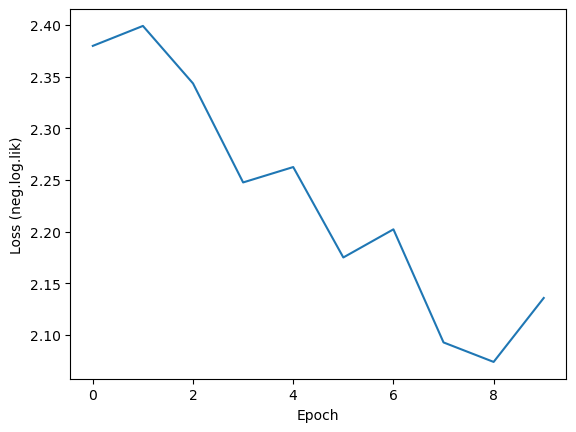

In [37]:
print(prior.mean())
model.compile(optimizer='adam', loss=lambda y_true, model_out: -model_out.log_prob(y_true))
hist = model.fit(ds, epochs=10, verbose=2)
loc_params = model.get_layer("c_params").weights
out_locs = np.ones((1, 1)) @ loc_params[0].numpy() + loc_params[1].numpy()
print(f"Model est dist mean: {out_locs}")
print(f"prior mean: {prior.mean()}")


# Plot Loss #
#############
plt.plot(hist.history['loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss (neg.log.lik)")
plt.show()


In [32]:
class U_Encoder(tfk.Model):    
    def __init__(self):      
        super(U_Encoder,self).__init__()
        self.alpha        = 1.5
        self.prior        = self.make_mvn_prior(1,True)
        self.dense1       = tfkl.Dense(5, activation ='relu',kernel_initializer =tfk.initializers.RandomUniform(minval=0.01, maxval=0.02))
        self.dense2       = tfkl.Dense(5, activation ='relu',kernel_initializer =tfk.initializers.RandomUniform(minval=0.01, maxval=0.02))
        self.dense3       = tfkl.Dense(2, activation='relu',bias_initializer = tfk.initializers.RandomUniform(minval=1, maxval=2))
        self.lambda1      = tfkl.Lambda(lambda x: tf.abs(x)+0.001)
        self.dist_lambda3 = tfpl.DistributionLambda(
                            make_distribution_fn=lambda t: (tfd.Gamma(
                                concentration=t[...,0], rate=t[...,1])),
            activity_regularizer=tfpl.KLDivergenceRegularizer(self.prior, use_exact_kl=True)
        )  
        
        #self.KL_Loss      = tfpl.KLDivergenceAddLoss()
        
    def make_mvn_prior(self,ndim, trainable):       
        if trainable:
            c = tf.Variable(tf.random.uniform([ndim], minval=2.1,maxval = 2.101, dtype=tf.float32), name='prior_c')
            print(c)
            rate = 1
        else:
            c = self.alpha
            rate = 1
        prior = (tfd.Gamma(concentration=c, rate=rate))
        return prior
    
        
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dist_lambda3(x)
        return(x)
    
 

In [33]:
enc = U_Encoder()

print(enc(train_dataset[:5]))
enc.summary()
negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)


<tf.Variable 'prior_c:0' shape=(1,) dtype=float32, numpy=array([2.100589], dtype=float32)>
tfp.distributions._TensorCoercible("u__encoder_distribution_lambda_10_tensor_coercible", batch_shape=[5], event_shape=[], dtype=float32)
Model: "u__encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            multiple                  10        
                                                                 
 dense_33 (Dense)            multiple                  30        
                                                                 
 dense_34 (Dense)            multiple                  12        
                                                                 
 lambda_12 (Lambda)          multiple                  0 (unused)
                                                                 
 distribution_lambda_10 (Dis  multiple                 1         
 tributionLambda)         

In [34]:

enc.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3),
            loss=negative_log_likelihood)

enc.fit(x=train_dataset,
	y=train_dataset, 
        #validation_data=(eval_dataset,eval_dataset), 
        batch_size=32,
        epochs=5)
print(enc.prior.concentration)

Epoch 1/5
8/8 [==============================] - 1s 5ms/step - loss: 2.3009
Epoch 2/5
8/8 [==============================] - 0s 4ms/step - loss: 2.2391
Epoch 3/5
8/8 [==============================] - 0s 4ms/step - loss: 2.1780
Epoch 4/5
8/8 [==============================] - 0s 6ms/step - loss: 2.1136
Epoch 5/5
8/8 [==============================] - 0s 4ms/step - loss: 2.0500
<tf.Variable 'prior_c:0' shape=(1,) dtype=float32, numpy=array([2.061332], dtype=float32)>


In [38]:
    
class U_Decoder(tfk.Model):
    def __init__(self):
        super(U_Decoder,self).__init__()
        
        self.dense1  = tfkl.Dense(5, use_bias=True, activation='relu')
        self.lambda1 = tfkl.Lambda(lambda x: 1/x)
        self.dense2  = tfkl.Dense(5, use_bias=True, activation='relu')
        self.dense31 = tfkl.Dense(1, use_bias=True)
        self.dense32 = tfkl.Dense(1, use_bias=True)
        self.lambda2 = tfkl.Lambda(lambda x: tf.abs(x)+0.001)
        self.concat1 = tfkl.Concatenate()
        self.dist_lambda1 = tfpl.DistributionLambda(
            make_distribution_fn=lambda t: tfd.Gamma(
                concentration=t[...,0], rate=t[...,1]))
        
        
    def call(self, inputs):
        y1     = tfkl.Reshape(target_shape=[1])(inputs)
        y     = self.lambda1(y1)
        x     = self.dense1(y)
        x     = self.dense2(x)
        alpha = self.dense31(x*y1)
        alpha = self.lambda2(alpha)
        beta  = self.dense32(x)
        beta  = self.lambda2(beta/y**2)
        x     = self.concat1([alpha,beta])
        x     = self.dist_lambda1(x)
        return x


In [39]:
   
class U_Ext_VAE(tfk.Model):
    def __init__(self):      
        super(U_Ext_VAE,self).__init__()
        self.encoder = U_Encoder()
        self.decoder = U_Decoder()
        #self.Block   = tfpl.DistributionLambda(
         #   make_distribution_fn=lambda d: tfd.Blockwise(
        #        d))
    
    def call(self,inputs):
        res =  self.decoder(self.encoder(inputs))
        return res

In [47]:
vae = U_Ext_VAE()

print(vae(train_dataset[:5]))



<tf.Variable 'prior_c:0' shape=(1,) dtype=float32, numpy=array([2.1002862], dtype=float32)>
tfp.distributions._TensorCoercible("u__ext_vae_2_u__decoder_2_distribution_lambda_16_tensor_coercible", batch_shape=[5], event_shape=[], dtype=float32)


In [50]:
negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)
vae.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4),
            loss=negative_log_likelihood)

vae.fit(x=train_dataset,
	y=train_dataset, 
        validation_data=(eval_dataset,eval_dataset), 
        batch_size=32,
        epochs=100)
print(vae.encoder.prior.concentration)

Epoch 1/100
8/8 [==============================] - 2s 85ms/step - loss: 2.2905 - val_loss: nan
Epoch 2/100
8/8 [==============================] - 0s 42ms/step - loss: 2.3243 - val_loss: nan
Epoch 3/100
8/8 [==============================] - 0s 47ms/step - loss: 2.2797 - val_loss: nan
Epoch 4/100
8/8 [==============================] - 0s 33ms/step - loss: 2.2825 - val_loss: nan
Epoch 5/100
8/8 [==============================] - 0s 29ms/step - loss: 2.2838 - val_loss: nan
Epoch 6/100
8/8 [==============================] - 0s 27ms/step - loss: 2.2494 - val_loss: nan
Epoch 7/100
8/8 [==============================] - 0s 29ms/step - loss: 2.2327 - val_loss: nan
Epoch 8/100
8/8 [==============================] - 0s 28ms/step - loss: 2.1874 - val_loss: nan
Epoch 9/100
8/8 [==============================] - 0s 35ms/step - loss: 2.2195 - val_loss: nan
Epoch 10/100
8/8 [==============================] - 0s 27ms/step - loss: 2.2630 - val_loss: nan
Epoch 11/100
8/8 [==============================]

In [219]:
class Encoder(tfk.Model):
    
    def __init__(self):      
        super(Encoder,self).__init__()   
        self.prior        = tfd.InverseGamma(concentration=1.5,scale=1)
        self.dense1       = tfkl.Dense(5, activation ='relu',kernel_initializer =tfk.initializers.Zeros())
        self.dense2       = tfkl.Dense(5, activation ='relu',kernel_initializer =tfk.initializers.Zeros())
        self.dense3       = tfkl.Dense(2, activation='relu',bias_initializer = tfk.initializers.RandomUniform(minval=1, maxval=2))
        self.lambda1      = tfkl.Lambda(lambda x: tf.abs(x)+0.001, name='posterior_params')
        self.dist_lambda1 = tfpl.DistributionLambda(
                            make_distribution_fn=lambda t: tfd.InverseGamma(
                                concentration=t[...,0], scale=t[...,1]),
                                    activity_regularizer=tfpl.KLDivergenceRegularizer(self.prior))  
        
        
    def call(self, inputs):
        print('encoder')
        print(inputs)
        x = self.dense1(inputs)
        print(x)
        x = self.dense2(x)
        print(x)
        x = self.dense3(x)
        print(x)
        x = self.lambda1(x)
        print(x)
        x = self.dist_lambda1(x)
        print(x)
        return x
    
class Decoder(tfk.Model):
    def __init__(self):
        super(Decoder,self).__init__()
        self.dense1  = tfkl.Dense(5, use_bias=True, activation='relu')
        self.dense2  = tfkl.Dense(5, use_bias=True, activation='relu')
        self.dense31 = tfkl.Dense(1, use_bias=True)
        self.dense32 = tfkl.Dense(1, use_bias=True)
        self.lambda1 = tfkl.Lambda(lambda x: tf.abs(x)+0.001)
        self.concat1 = tfkl.Concatenate()
        self.dist_lambda1 = tfpl.DistributionLambda(
            make_distribution_fn=lambda t: tfd.Gamma(
                concentration=t[...,0], rate=t[...,1]))
        
        
    def call(self, inputs):
        print('decoder')
        print(inputs)
        x     = tfkl.Reshape(target_shape=[1])(inputs)
        print(x)
        x     = self.dense1(x)
        print(x)
        x     = self.dense2(x)
        alpha = self.dense31(x)
        alpha = self.lambda1(alpha)
        beta  = self.dense32(x)
        beta  = self.lambda1(beta/inputs**2)
        x     = self.concat1([alpha,beta])
        x     = self.dist_lambda1(x)
        return x
    
class Ext_VAE(tfk.Model):
    def __init__(self):      
        super(Ext_VAE,self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self,inputs):
        return self.decoder(self.encoder(inputs))
    

In [175]:
vae_k = Ext_VAE()

In [176]:
print(vae_k(train_dataset[:5]))

encoder
tf.Tensor(
[[ 0.5922747 ]
 [ 0.26953256]
 [ 0.6041775 ]
 [27.71446   ]
 [ 0.4887664 ]], shape=(5, 1), dtype=float32)
tf.Tensor(
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]], shape=(5, 5), dtype=float32)
tf.Tensor(
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]], shape=(5, 5), dtype=float32)
tf.Tensor(
[[1.2782958 1.9192564]
 [1.2782958 1.9192564]
 [1.2782958 1.9192564]
 [1.2782958 1.9192564]
 [1.2782958 1.9192564]], shape=(5, 2), dtype=float32)
tf.Tensor(
[[1.2792958 1.9202565]
 [1.2792958 1.9202565]
 [1.2792958 1.9202565]
 [1.2792958 1.9202565]
 [1.2792958 1.9202565]], shape=(5, 2), dtype=float32)
tfp.distributions._TensorCoercible("ext_vae_6_encoder_6_distribution_lambda_48_tensor_coercible", batch_shape=[5], event_shape=[], dtype=float32)
decoder
tfp.distributions._TensorCoercible("ext_vae_6_encoder_6_distribution_lambda_48_tensor_coercible", batch_shape=[5], event_shape=[], dtype=float3

In [31]:
# Model with unknown prior
class U_Encoder2(tfk.Model):    
    def __init__(self):      
        super(U_Encoder2,self).__init__()
        self.alpha        = 1.5
        self.c            = tf.Variable(tf.random.uniform([1], minval=1,maxval = 2, dtype=tf.float32), name='prior_c')
        self.prior        = self.make_mvn_prior(1,True)
        self.dense1       = tfkl.Dense(5, activation ='relu',kernel_initializer =tfk.initializers.RandomUniform(minval=0.01, maxval=0.02))
        self.dense2       = tfkl.Dense(5, activation ='relu',kernel_initializer =tfk.initializers.RandomUniform(minval=0.01, maxval=0.02))
        self.dense3       = tfkl.Dense(2, activation='relu',bias_initializer = tfk.initializers.RandomUniform(minval=1, maxval=2))
        self.lambda1      = tfkl.Lambda(lambda x: tf.abs(x)+0.001)
        self.dist_lambda3 = tfpl.DistributionLambda(
                            make_distribution_fn=lambda t: (tfd.Gamma(
                                concentration=t[...,0], rate=t[...,1])),
            activity_regularizer=tfpl.KLDivergenceRegularizer(self.prior, use_exact_kl=True)
        )  
        
        #self.KL_Loss      = tfpl.KLDivergenceAddLoss()
        
    def make_mvn_prior(self,ndim, trainable):       
        if trainable:
            c = self.c
            print(c)
            rate = 1
        else:
            c = self.alpha
            rate = 1
        prior = (tfd.Gamma(concentration=c, rate=rate))
        return prior
    
        
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dist_lambda3(x)
        return(x)
    
 
 
class U_Decoder2(tfk.Model):
    def __init__(self):
        super(U_Decoder2,self).__init__()
        
        self.dense1  = tfkl.Dense(5, use_bias=True, activation='relu')
        self.lambda1 = tfkl.Lambda(lambda x: 1/x)
        self.dense2  = tfkl.Dense(5, use_bias=True, activation='relu')
        self.dense31 = tfkl.Dense(1, use_bias=True)
        self.dense32 = tfkl.Dense(1, use_bias=True)
        self.lambda2 = tfkl.Lambda(lambda x: tf.abs(x)+0.001)
        self.concat1 = tfkl.Concatenate()
        self.dist_lambda1 = tfpl.DistributionLambda(
            make_distribution_fn=lambda t: tfd.Gamma(
                concentration=t[...,0], rate=t[...,1]))
        
        
    def call(self, inputs):
        y     = tfkl.Reshape(target_shape=[1])(inputs)
        y     = self.lambda1(y)
        x     = self.dense1(y)
        x     = self.dense2(x)
        alpha = self.dense31(x/y)
        alpha = self.lambda1(alpha)
        beta  = self.dense32(x)
        beta  = self.lambda2(beta/y**2)
        x     = self.concat1([alpha,beta])
        x     = self.dist_lambda1(x)
        return x

    
class U_Ext_VAE2(tfk.Model):
    def __init__(self):      
        super(U_Ext_VAE2,self).__init__()
        self.encoder = U_Encoder2()
        self.decoder = U_Decoder2()
        #self.Block   = tfpl.DistributionLambda(
         #   make_distribution_fn=lambda d: tfd.Blockwise(
        #        d))
    
    def call(self,inputs):
        res =  self.decoder(self.encoder(inputs))
        return res
    
# Standard VAE as competitor

In [309]:
G = tfpl.VariableLayer(shape=[3], initializer = 'ones')
print(G([3,5,10]))
enco = U_Encoder2()
print(enco(train_dataset[:5]))
print(enco.c)

tf.Tensor([1. 1. 1.], shape=(3,), dtype=float32)
<tf.Variable 'prior_c:0' shape=(1,) dtype=float32, numpy=array([1.3221647], dtype=float32)>
tfp.distributions._TensorCoercible("u__encoder2_18_distribution_lambda_91_tensor_coercible", batch_shape=[5], event_shape=[], dtype=float32)
<tf.Variable 'prior_c:0' shape=(1,) dtype=float32, numpy=array([1.3221647], dtype=float32)>


In [310]:


enco.summary()
enco.get_weights()

Model: "u__encoder2_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_303 (Dense)           multiple                  10        
                                                                 
 dense_304 (Dense)           multiple                  30        
                                                                 
 dense_305 (Dense)           multiple                  12        
                                                                 
 lambda_105 (Lambda)         multiple                  0 (unused)
                                                                 
 distribution_lambda_91 (Dis  multiple                 1         
 tributionLambda)                                                
                                                                 
Total params: 53
Trainable params: 53
Non-trainable params: 0
________________________________________________________

[array([1.3221647], dtype=float32),
 array([[0.01622628, 0.0197575 , 0.01816324, 0.01926297, 0.01248426]],
       dtype=float32),
 array([0., 0., 0., 0., 0.], dtype=float32),
 array([[0.01893114, 0.01302198, 0.01395604, 0.01376069, 0.0197444 ],
        [0.0129853 , 0.01052482, 0.01933458, 0.01453449, 0.01571166],
        [0.01918814, 0.01771098, 0.01112029, 0.01351321, 0.01090526],
        [0.01297861, 0.01755456, 0.01433524, 0.01858643, 0.01950116],
        [0.01476115, 0.01123269, 0.01905973, 0.0194897 , 0.01717541]],
       dtype=float32),
 array([0., 0., 0., 0., 0.], dtype=float32),
 array([[ 0.813419  , -0.5900625 ],
        [-0.65594196, -0.75153774],
        [ 0.20350325,  0.8429414 ],
        [-0.35190642,  0.53639483],
        [-0.88005733, -0.1692347 ]], dtype=float32),
 array([1.2374572, 1.3579409], dtype=float32)]

In [290]:
enco.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3),
            loss=negative_log_likelihood)

enco.fit(x=train_dataset,
	y=train_dataset, 
        #validation_data=(eval_dataset,eval_dataset), 
        batch_size=32,
        epochs=5)
print(enco.var1([0]))

Epoch 1/5
8/8 [==============================] - 1s 4ms/step - loss: 1.1720
Epoch 2/5
8/8 [==============================] - 0s 3ms/step - loss: 1.1660
Epoch 3/5
8/8 [==============================] - 0s 3ms/step - loss: 1.1604
Epoch 4/5
8/8 [==============================] - 0s 3ms/step - loss: 1.1532
Epoch 5/5
8/8 [==============================] - 0s 3ms/step - loss: 1.1464
tf.Tensor([1.], shape=(1,), dtype=float32)


In [51]:
checkpoint_path = '/home/nlafon/These/Extreme_VAE/tmp/radius1/Ext_VAE/Learnable_prior2/U_Ext_VAE_checkpoint'


In [324]:
import tensorflow as tf
from tensorflow.python.training import checkpoint_utils as cp

print(cp.list_variables(checkpoint_path))
print(cp.load_variable(checkpoint_path,name = 'encoder/prior/_concentration/.ATTRIBUTES/VARIABLE_VALUE'))

[('_CHECKPOINTABLE_OBJECT_GRAPH', []), ('decoder/dense1/bias/.ATTRIBUTES/VARIABLE_VALUE', [5]), ('decoder/dense1/bias/.OPTIMIZER_SLOT/optimizer/m/.ATTRIBUTES/VARIABLE_VALUE', [5]), ('decoder/dense1/bias/.OPTIMIZER_SLOT/optimizer/v/.ATTRIBUTES/VARIABLE_VALUE', [5]), ('decoder/dense1/kernel/.ATTRIBUTES/VARIABLE_VALUE', [1, 5]), ('decoder/dense1/kernel/.OPTIMIZER_SLOT/optimizer/m/.ATTRIBUTES/VARIABLE_VALUE', [1, 5]), ('decoder/dense1/kernel/.OPTIMIZER_SLOT/optimizer/v/.ATTRIBUTES/VARIABLE_VALUE', [1, 5]), ('decoder/dense2/bias/.ATTRIBUTES/VARIABLE_VALUE', [5]), ('decoder/dense2/bias/.OPTIMIZER_SLOT/optimizer/m/.ATTRIBUTES/VARIABLE_VALUE', [5]), ('decoder/dense2/bias/.OPTIMIZER_SLOT/optimizer/v/.ATTRIBUTES/VARIABLE_VALUE', [5]), ('decoder/dense2/kernel/.ATTRIBUTES/VARIABLE_VALUE', [5, 5]), ('decoder/dense2/kernel/.OPTIMIZER_SLOT/optimizer/m/.ATTRIBUTES/VARIABLE_VALUE', [5, 5]), ('decoder/dense2/kernel/.OPTIMIZER_SLOT/optimizer/v/.ATTRIBUTES/VARIABLE_VALUE', [5, 5]), ('decoder/dense31/bias/

In [52]:
import Prob_models as PM

In [53]:
vae_test = PM.U_Ext_VAE()
vae_test.load_weights(checkpoint_path)

<tf.Variable 'prior_c:0' shape=(1,) dtype=float32, numpy=array([1.4716179], dtype=float32)>


In [54]:
print(vae_test.encoder.prior.concentration)

<tf.Variable 'prior_c:0' shape=(1,) dtype=float32, numpy=array([1.2315114], dtype=float32)>


In [19]:
class U_Encoder2(tfk.Model):    
    def __init__(self):      
        super(U_Encoder2,self).__init__()
        self.alpha        = 1.5
        self.alpha_tot  = tf.Variable(tf.random.uniform([1], minval=2,maxval = 2.5, dtype=tf.float32), name='alpha_post')
        self.prior        = self.make_mvn_prior(1,True)
        self.dense1       = tfkl.Dense(5, activation ='relu',kernel_initializer =tfk.initializers.RandomUniform(minval=0.01, maxval=0.02))
        self.dense2       = tfkl.Dense(5, activation ='relu',kernel_initializer =tfk.initializers.RandomUniform(minval=0.01, maxval=0.02))
        self.dense3       = tfkl.Dense(1, activation='relu',bias_initializer = tfk.initializers.RandomUniform(minval=1, maxval=2))
        self.lambda1      = tfkl.Lambda(lambda x: tf.abs(x)+0.001)
        self.dist_lambda3 = tfpl.DistributionLambda(
                            make_distribution_fn=lambda t: (tfd.Gamma(
                                concentration=self.alpha_post, rate=t[...,0])),
            activity_regularizer=tfpl.KLDivergenceRegularizer(self.prior, use_exact_kl=True)
        )  
        
        #self.KL_Loss      = tfpl.KLDivergenceAddLoss()
        
    def make_mvn_prior(self,ndim, trainable):       
        if trainable:
            c = self.alpha_tot
            print(c)
            rate = 1
        else:
            c = self.alpha
            rate = 1
        prior = (tfd.Gamma(concentration=c, rate=rate))
        return prior
    
        
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dist_lambda3(x)
        return(x)
    
 
 
class U_Decoder2(tfk.Model):
    def __init__(self):
        super(U_Decoder2,self).__init__()
        
        self.dense1  = tfkl.Dense(5, use_bias=True, activation='relu')
        self.lambda1 = tfkl.Lambda(lambda x: 1/x)
        self.dense2  = tfkl.Dense(5, use_bias=True, activation='relu')
        self.dense31 = tfkl.Dense(1, use_bias=True)
        self.dense32 = tfkl.Dense(1, use_bias=True)
        self.lambda2 = tfkl.Lambda(lambda x: tf.abs(x)+0.001)
        self.concat1 = tfkl.Concatenate()
        self.dist_lambda1 = tfpl.DistributionLambda(
            make_distribution_fn=lambda t: tfd.Gamma(
                concentration=t[...,0], rate=t[...,1]))
        
        
    def call(self, inputs):
        y     = tfkl.Reshape(target_shape=[1])(inputs)
        y     = self.lambda1(y)
        x     = self.dense1(y)
        x     = self.dense2(x)
        alpha = self.dense31(x)
        alpha = self.lambda1(alpha)
        beta  = self.dense32(x)
        beta  = self.lambda2(beta/y**2)
        x     = self.concat1([alpha,beta])
        x     = self.dist_lambda1(x)
        return x

    
class U_Ext_VAE2(tfk.Model):
    def __init__(self):      
        super(U_Ext_VAE2,self).__init__()
        self.encoder = U_Encoder2()
        self.decoder = U_Decoder2()
        #self.Block   = tfpl.DistributionLambda(
         #   make_distribution_fn=lambda d: tfd.Blockwise(
        #        d))
    
    def call(self,inputs):
        res =  self.decoder(self.encoder(inputs))
        return res
    

In [20]:
enco = U_Encoder2()
print(enco.alpha_post)
negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)
enco.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3),
            loss=negative_log_likelihood)

enco.fit(x=train_dataset,
	y=train_dataset, 
        #validation_data=(eval_dataset,eval_dataset), 
        batch_size=32,
        epochs=5)
print(enco.alpha_post)

<tf.Variable 'prior_c:0' shape=(1,) dtype=float32, numpy=array([2.3300772], dtype=float32)>
<tf.Variable 'alpha_post:0' shape=(1,) dtype=float32, numpy=array([2.043808], dtype=float32)>
Epoch 1/5
The following Variables were used a Lambda layer's call (distribution_lambda_5), but
are not present in its tracked objects:
  <tf.Variable 'alpha_post:0' shape=(1,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
8/8 [==============================] - 1s 3ms/step - loss: 2.6306
Epoch 2/5
8/8 [==============================] - 0s 3ms/step - loss: 2.5832
Epoch 3/5
8/8 [==============================] - 0s 3ms/step - loss: 2.5361
Epoch 4/5
8/8 [==============================] - 0s 3ms/step - loss: 2.4876
Epoch 5/5
8/8 [==============================] - 0s 3ms/step - loss: 2.4392
<tf.Variable 'alpha_post:0' shape=(1,) dtype=float32, nu

In [22]:
vae = U_Ext_VAE2()
print(vae.encoder.prior.concentration)
print(vae.encoder.alpha_post)

<tf.Variable 'prior_c:0' shape=(1,) dtype=float32, numpy=array([2.0348763], dtype=float32)>
<tf.Variable 'prior_c:0' shape=(1,) dtype=float32, numpy=array([2.0348763], dtype=float32)>
<tf.Variable 'alpha_post:0' shape=(1,) dtype=float32, numpy=array([2.3697517], dtype=float32)>


In [30]:

vae.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-5),
            loss=negative_log_likelihood)

vae.fit(x=train_dataset,
	y=train_dataset, 
        validation_data=(eval_dataset,eval_dataset), 
        batch_size=32,
        epochs=1000)
print(vae.encoder.prior.concentration)
print(vae.encoder.alpha_post)

Epoch 1/1000
8/8 [==============================] - 2s 107ms/step - loss: 1.0746 - val_loss: 1.1184
Epoch 2/1000
8/8 [==============================] - 0s 25ms/step - loss: 1.0820 - val_loss: 1.1290
Epoch 3/1000
8/8 [==============================] - 0s 27ms/step - loss: 1.0814 - val_loss: 1.1142
Epoch 4/1000
8/8 [==============================] - 0s 35ms/step - loss: 1.0767 - val_loss: 1.1217
Epoch 5/1000
8/8 [==============================] - 0s 26ms/step - loss: 1.0858 - val_loss: 1.1273
Epoch 6/1000
8/8 [==============================] - 0s 26ms/step - loss: 1.0885 - val_loss: 1.1206
Epoch 7/1000
8/8 [==============================] - 0s 24ms/step - loss: 1.0777 - val_loss: 1.1220
Epoch 8/1000
8/8 [==============================] - 0s 27ms/step - loss: 1.0862 - val_loss: 1.1225
Epoch 9/1000
8/8 [==============================] - 0s 25ms/step - loss: 1.0765 - val_loss: 1.1159
Epoch 10/1000
8/8 [==============================] - 0s 27ms/step - loss: 1.0831 - val_loss: 1.1356
Epoch 11

In [6]:
num_components =2
ev_shape = [1]
tfpl.MixtureSameFamily.params_size(num_components,
                                                 component_params_size=tfpl.IndependentNormal.params_size(ev_shape))

6

In [10]:
tfpl.MixtureSameFamily.params_size(num_components,
                                                 component_params_size=2)



6

In [44]:
mixt_dist1     = tfpl.MixtureSameFamily(2, tfpl.DistributionLambda(
            make_distribution_fn=lambda t: tfd.Gamma(
                concentration=t[...,0], rate=t[...,1])))



samples = mixt_dist1([[0.,0.,0.01,2.,10.,10.]]).sample(10000)

/tmp/ipykernel_91612/1549178342.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(samples)


TypeError: list indices must be integers or slices, not tuple

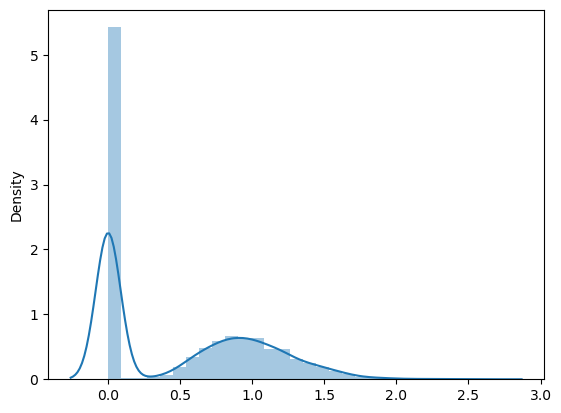

In [49]:
import seaborn as sns
sns.distplot(samples)
g = lambda t: tfd.Gamma(
                concentration=t[...,0], rate=t[...,1])

g([[0.01,2.,10.,10.]])

In [3]:
A  = 2*tfd.Uniform().sample(1000)
X  = tfd.InverseGamma(concentration =1.5, scale = 0.6 ).sample(1000)
R1 = A*X

2022-11-15 14:33:11.081407: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-15 14:33:11.083836: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [5]:
print(tf.sort(R1)[500])

tf.Tensor(0.47068053, shape=(), dtype=float32)


In [75]:
Ber = tfd.Bernoulli(probs=0.3, dtype ='float').sample(1000) 
IG1 = tfd.InverseGamma(concentration =1.8, scale = 1 ).sample(1000)
IG2 = tfd.InverseGamma(concentration =1.8, scale = 1 ).sample(1000)
R2 = IG1*Ber +(6+IG2)*(1-Ber)

train_dataset = R2[:250]
train_dataset = tf.reshape(train_dataset,[250,1])
eval_dataset = R2[250:]
eval_dataset=tf.reshape(eval_dataset,[750,1])

/tmp/ipykernel_14732/4270754263.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Y_sort)


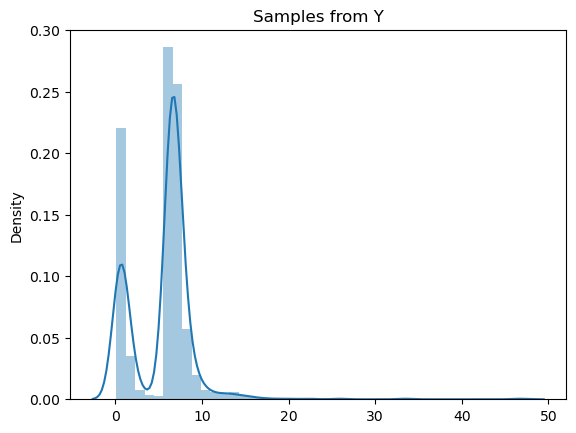

In [76]:
Y_sort=tf.sort(Y)
sns.distplot(Y_sort)
plt.title("Samples from Y")
plt.show()

In [3]:

#Model with known prior
class Encoder(tfk.Model):
    
    def __init__(self):      
        super(Encoder,self).__init__()      
        self.prior        = tfd.Gamma(concentration=1.5,rate = 1)
        self.dense1       = tfkl.Dense(5, activation ='relu',kernel_initializer =tfk.initializers.Zeros())
        self.dense2       = tfkl.Dense(5, activation ='relu',kernel_initializer =tfk.initializers.Zeros())
        self.dense3       = tfkl.Dense(2, activation='relu',bias_initializer = tfk.initializers.RandomUniform(minval=1, maxval=2))
        self.lambda1      = tfkl.Lambda(lambda x: tf.abs(x)+0.001, name='posterior_params')
        self.dist_lambda1 = tfpl.DistributionLambda(
                            make_distribution_fn=lambda t: tfd.Gamma(
                                concentration=t[...,0], rate = t[...,1]),
                                    activity_regularizer=tfpl.KLDivergenceRegularizer(self.prior,use_exact_kl =True))  
        
        
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.lambda1(x)
        x = self.dist_lambda1(x)
        return x
    
class Decoder(tfk.Model):
    def __init__(self):
        super(Decoder,self).__init__()
        self.dense1       = tfkl.Dense(5, use_bias=True, activation='relu')
        self.lambda1      = tfkl.Lambda(lambda x: 1/x)
        self.dense2       = tfkl.Dense(5, use_bias=True, activation='relu')
        self.dense31      = tfkl.Dense(1, use_bias=True,bias_initializer = tfk.initializers.RandomUniform(minval=1, maxval=2))
        self.dense32      = tfkl.Dense(1, use_bias=True,bias_initializer = tfk.initializers.RandomUniform(minval=1, maxval=2), kernel_initializer = tfk.initializers.RandomUniform(minval=0.1, maxval=2))
        self.dense3       = tfkl.Dense(2, activation='relu',bias_initializer = tfk.initializers.RandomUniform(minval=1, maxval=2))
        self.lambda2      = tfkl.Lambda(lambda x: tf.abs(x)+0.00001)
        self.concat1      = tfkl.Concatenate()
        self.dist_lambda1 = tfpl.DistributionLambda(
            make_distribution_fn=lambda t: tfd.Gamma(
                concentration=t[...,0], rate=t[...,1]))
        self.dist_n       = tfpl.IndependentNormal(1)
        self.ind_norm1 = tfpl.DistributionLambda(
                            make_distribution_fn=lambda v: tfd.TruncatedNormal(
                                loc=v[...,0], scale=v[...,1],low = 0,high = 1000))
        
        
    def call(self, inputs):
        y     = tfkl.Reshape(target_shape=[1])(inputs)
        y1    = self.lambda1(y)
        x     = self.dense1(y1)
        x     = self.dense2(x)
        
        #for gamma output :       
        alpha = self.dense31(x*y)
        alpha = self.lambda1(alpha)
        beta  = self.dense32(x)
        beta  = self.lambda2(beta*y**2)
        x     = self.concat1([alpha,beta])                
        x     = self.dist_lambda1(x)
        
        #normal output or truncated normal:
        #mu    = self.dense31(x)
        #sig   = self.dense32(x)
        #sig   = self.lambda1(sig/(1+y1))
        #x     = self.concat1([mu,sig])
        #x     = self.dist_n(x)
        #x     = self.ind_norm1(x)
        
        return x
    
class Ext_VAE(tfk.Model):
    def __init__(self):      
        super(Ext_VAE,self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self,inputs):
        return self.decoder(self.encoder(inputs))

In [143]:
vae = Ext_VAE()
vae.decoder.get_weights()

[]

In [8]:
import random
import numpy as np
seed = 100
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
A = 2*tfd.Uniform().sample(1000)
X = tfd.InverseGamma(concentration =1.5, scale = 0.6 ).sample(1000)
R1 = A*X

random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
train_dataset = R1[:250]
train_dataset = tf.reshape(train_dataset,[250,1])
eval_dataset = R1[250:]
eval_dataset=tf.reshape(eval_dataset,[750,1])
print(np.max(R1))
print(np.max(R1[:250]))

165.50166
16.883898


In [65]:
negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

vae.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4),
            loss=negative_log_likelihood)

In [66]:
vae.fit(train_dataset,train_dataset, 
        validation_data=(eval_dataset,eval_dataset), 
        batch_size=32,
        epochs=1000
       )

Epoch 1/1000
8/8 [==============================] - 2s 84ms/step - loss: 0.8884 - val_loss: 1.0874
Epoch 2/1000
8/8 [==============================] - 0s 63ms/step - loss: 0.9164 - val_loss: 1.0951
Epoch 3/1000
8/8 [==============================] - 0s 70ms/step - loss: 0.9062 - val_loss: 1.0967
Epoch 4/1000
8/8 [==============================] - 0s 66ms/step - loss: 0.9051 - val_loss: 1.0989
Epoch 5/1000
8/8 [==============================] - 0s 56ms/step - loss: 0.8829 - val_loss: 1.1041
Epoch 6/1000
8/8 [==============================] - 0s 34ms/step - loss: 0.8798 - val_loss: 1.0900
Epoch 7/1000
8/8 [==============================] - 0s 27ms/step - loss: 0.9049 - val_loss: 1.0834
Epoch 8/1000
8/8 [==============================] - 0s 42ms/step - loss: 0.9002 - val_loss: 1.1079
Epoch 9/1000
8/8 [==============================] - 0s 43ms/step - loss: 0.8855 - val_loss: 1.0933
Epoch 10/1000
8/8 [==============================] - 0s 37ms/step - loss: 0.8660 - val_loss: 1.0966
Epoch 11/

KeyboardInterrupt: 

In [67]:
N_samples = 10000
prior_samples = vae.encoder.prior.sample(N_samples)
print(tf.reduce_max(prior_samples))
print(tf.reduce_min(prior_samples))
samples_vae = vae.decoder(prior_samples).sample()
print(samples_vae)

tf.Tensor(10.197591, shape=(), dtype=float32)
tf.Tensor(0.002986619, shape=(), dtype=float32)
tf.Tensor([2.2816095  0.6936851  0.16705951 ... 0.7811353  1.9303243  4.2003145 ], shape=(10000,), dtype=float32)


In [ ]:
# Samples from R1
N_samples = 10000
A = 2*tfd.Uniform().sample(N_samples)
X = tfd.InverseGamma(concentration =1.5, scale = 0.6 ).sample(N_samples)
test_set = A*X
test_set =test_set.numpy()

tf.Tensor(1.6301888, shape=(), dtype=float32)
tf.Tensor(1.6301888, shape=(), dtype=float32)
tf.Tensor(
[2.9866190e-03 3.1623163e-03 7.8775650e-03 ... 9.4497108e+00 9.7904654e+00
 1.0197591e+01], shape=(10000,), dtype=float32)
tf.Tensor(0.5525508, shape=(), dtype=float32)
tf.Tensor(0.00013467361, shape=(), dtype=float32)


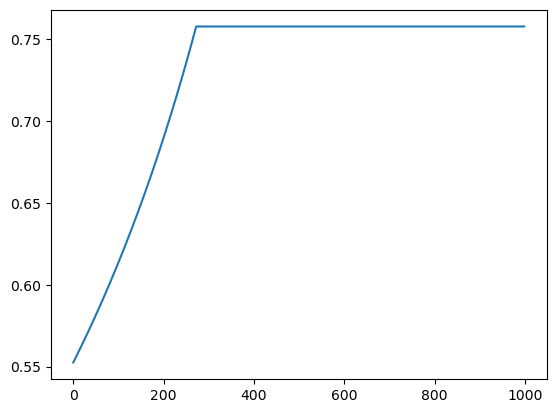

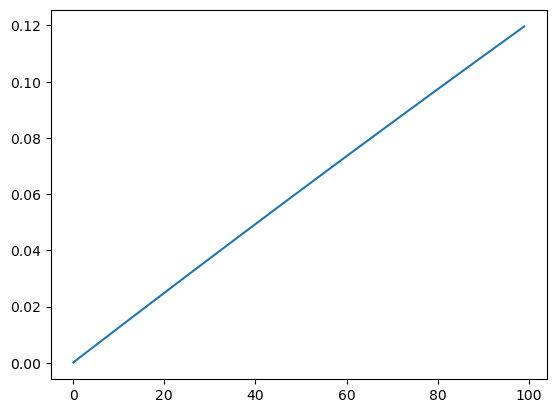

In [68]:
import matplotlib.pyplot as plt
U = vae.encoder(tf.expand_dims(np.arange(1,1000,1),-1)).concentration
print(U[898])
print(U[998])
print(tf.sort(prior_samples))
c_vae = vae.decoder((np.arange(0.01,10,0.01,dtype = float))).concentration
print(c_vae[0])
plt.plot(c_vae)
plt.figure()
r_vae = vae.decoder((np.arange(0.0001,0.1,0.001,dtype = float))).rate
print(r_vae[0])
plt.plot(r_vae)

(10000,)


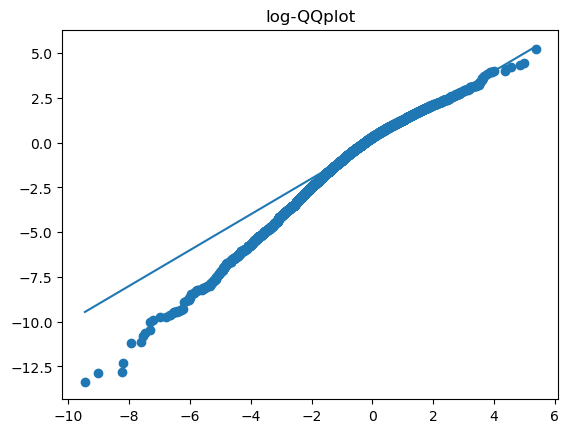

In [69]:
print(samples_vae.shape)
plt.figure()
plt.title('log-QQplot')
plt.scatter(tf.math.log(tf.sort(test_set[:])),tf.math.log(tf.sort(samples_vae)[:]))
plt.plot(tf.math.log(tf.sort(test_set)[:]),tf.math.log(tf.sort(test_set)[:]))

In [70]:
data_test = tf.reshape(test_set,(N_samples,1))
negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)
vae.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4),
            loss=negative_log_likelihood)
vae.evaluate(data_test,data_test,batch_size=32)

313/313 [==============================] - 1s 4ms/step - loss: 1.1204


1.1204229593276978

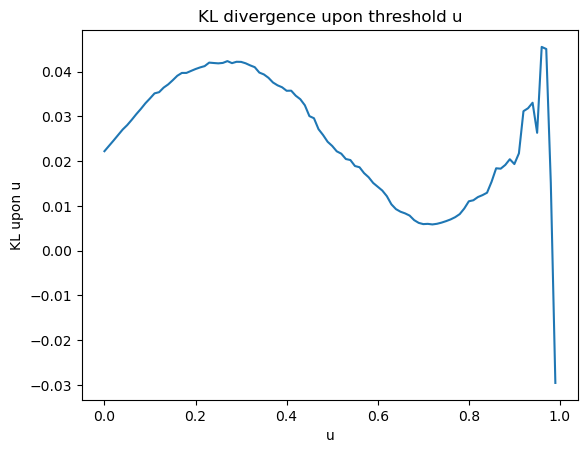

In [71]:
from statsmodels.distributions.empirical_distribution import ECDF
def tail_mod(f,n,x):
    return((n/n+1)*(1-f(x))+1/(n+1))



def L(X,Y,u):
    Nn = np.sum(X>u)
    m=Y.shape[0]
    fY=ECDF(Y)
    Xmax = np.maximum(X,u)
    Xu = np.minimum(Xmax,u)
    res = 1 + 1/Nn*(np.sum(np.log(tail_mod(fY,m,Xmax)/tail_mod(fY,m,Xu))))
    return(res)
    
def K(X,Y,u):
    res = -L(X,Y,u)-L(Y,X,u)
    return res
X = np.arange(0,1,0.01)
Ind = X*10000
Ind = Ind.astype('int64')

Q = np.sort(samples_vae)[Ind]
#Q = np.sort(test_set)[Ind]

Y = [K(test_set,samples_vae,qi) for qi in Q]
plt.figure()
plt.title("KL divergence upon threshold u")
plt.xlabel("u")
plt.ylabel("KL upon u")
plt.plot(X,Y)

In [54]:
vae.save_weights("Ext_VAE_custom_outputG_fig3")

In [172]:

# Model for bivariate distribution :
class Multi_Encoder(tfk.Model):
    
    def __init__(self):      
        super(Multi_Encoder,self).__init__()      
        self.prior        = tfd.Gamma(concentration=1.8,rate = 1)
        self.dense1       = tfkl.Dense(5, activation ='relu',kernel_initializer =tfk.initializers.Zeros())
        self.dense2       = tfkl.Dense(5, activation ='relu',kernel_initializer =tfk.initializers.Zeros())
        self.dense3       = tfkl.Dense(2, activation='relu',bias_initializer = tfk.initializers.RandomUniform(minval=1, maxval=2))
        self.lambda1      = tfkl.Lambda(lambda x: tf.abs(x)+0.001, name='posterior_params')
        self.dist_lambda1 = tfpl.DistributionLambda(
                            make_distribution_fn=lambda t: tfd.Gamma(
                                concentration=t[...,0], rate = t[...,1]),
                                    activity_regularizer=tfpl.KLDivergenceRegularizer(self.prior,use_exact_kl =True))  
        
        
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.lambda1(x)
        x = self.dist_lambda1(x)
        return x
    
class Multi_Decoder(tfk.Model):
    def __init__(self):
        super(Multi_Decoder,self).__init__()
        self.num_components = 2
        self.ev_shape       = [1]
        self.params_size    = tfpl.MixtureSameFamily.params_size(self.num_components,
                                                 component_params_size=tfpl.IndependentNormal.params_size(self.ev_shape))
        self.lambda1        = tfkl.Lambda(lambda x: 1/x)
        self.dense1         = tfkl.Dense(8, use_bias=True, activation='relu')
        self.dense2         = tfkl.Dense(8, use_bias=True, activation='relu')
        self.dense3         = tfkl.Dense(self.params_size,activation = 'relu')
        self.dense41        = tfkl.Dense(2, 
                                         bias_initializer = tfk.initializers.RandomUniform(minval=-0.1, maxval=0.1))
        self.dense421       = tfkl.Dense(1, 
                                         bias_initializer = tfk.initializers.RandomUniform(minval=1, maxval=2))
        self.dense422       = tfkl.Dense(1, 
                                         bias_initializer = tfk.initializers.RandomUniform(minval=0.5, maxval=2))
        self.dense431       = tfkl.Dense(1, 
                                         bias_initializer = tfk.initializers.RandomUniform(minval=5, maxval=10))
        self.dense432       = tfkl.Dense(1, 
                                         bias_initializer = tfk.initializers.RandomUniform(minval=0.5, maxval=2))
        self.lambda2        = tfkl.Lambda(lambda x: tf.abs(x)+0.001)
        self.concat1        = tfkl.Concatenate()
        self.mixt_distn1    = tfpl.MixtureSameFamily(self.num_components, tfpl.IndependentNormal(self.ev_shape))
        self.mixt_distg1    = tfpl.MixtureSameFamily(self.num_components, 
                                                     tfpl.DistributionLambda(
                                                         make_distribution_fn=lambda t: tfd.Gamma(
                                                             concentration=t[...,0], rate=t[...,1])))
        self.dense31        = tfkl.Dense(3, use_bias=True)
        self.dense32        = tfkl.Dense(3, activation='relu',
                                         bias_initializer = tfk.initializers.RandomUniform(minval=0.5, maxval=10))
        self.dense33        = tfkl.Dense(3, activation='relu',
                                         bias_initializer = tfk.initializers.RandomUniform(minval=1, maxval=2))
        #self.lambdan        = tfkl.Lambda(lambda x: tf.abs(x)+0.001)

        
    def call(self, inputs):
        y     = tfkl.Reshape(target_shape=[1])(inputs)
        y1    = self.lambda1(y)
        x     = self.dense1(y1)
        x     = self.dense2(x)
        
        # normal mixture
        x     = self.dense3(x)
        m     = self.dense41(x)
        #mu1   = self.dense421(x)
        #sig1  = self.dense431(x)
        #mu2   = self.dense422(x)
        #sig2  = self.dense432(x)
        #x     = self.concat1([m,mu1,sig1,mu2,sig2])
        #x     = self.lambda2(x)
        #x     = self.lambda2(x)
        #x     = self.mixt_distn1(x)
        
        # Gamma mixture 
        #m     = self.dense1(x)
        alpha1 = self.dense421(x*y)
        beta1  = self.dense431(x*y**2)
        alpha2 = self.dense422(x*y)
        beta2  = self.dense432(x*y**2)
        #beta  = self.lambda2(beta*inputs**2)
        x     = self.concat1([m,alpha1,alpha2,beta1,beta2])
        x     = self.mixt_distg1(x)
        return x
    
class Ext_Multi_VAE(tfk.Model):
    def __init__(self):      
        super(Ext_Multi_VAE,self).__init__()
        self.encoder = Multi_Encoder()
        self.decoder = Multi_Decoder()
    
    def call(self,inputs):
        return self.decoder(self.encoder(inputs))
    
    

In [173]:
vae = Ext_Multi_VAE()
print(vae.decoder(prior_samples[:5]).mixture_distribution.logits)
print(vae.decoder(prior_samples[:5]).components_distribution.concentration)
print(vae.decoder(prior_samples[:5]).components_distribution.rate)
vae.get_weights()

tf.Tensor(
[[-0.09955619 -0.04183851]
 [-0.10876495 -0.04717345]
 [-0.07523783 -0.02775008]
 [-0.08581369 -0.03387702]
 [-0.08209597 -0.03172323]], shape=(5, 2), dtype=float32)
tf.Tensor(
[[1.5507519 8.251749 ]
 [1.5507519 8.245164 ]
 [1.5507519 8.324661 ]
 [1.5507519 8.272276 ]
 [1.5507519 8.283415 ]], shape=(5, 2), dtype=float32)
tf.Tensor(
[[1.4904255  0.89043885]
 [1.4904255  0.8954696 ]
 [1.4904255  0.83473307]
 [1.4904255  0.8747557 ]
 [1.4904255  0.86624527]], shape=(5, 2), dtype=float32)


[array([[-0.74354327, -0.45194972,  0.5091895 ,  0.3424754 ,  0.3378036 ,
          0.06386858,  0.7238271 , -0.20873505]], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 array([[ 0.38449967, -0.18625155,  0.4458235 , -0.54245096, -0.4876092 ,
          0.05015701,  0.06745744, -0.37833086],
        [ 0.15975541,  0.60087675, -0.3013177 , -0.42886442,  0.27348244,
          0.3199556 , -0.1881164 ,  0.19850498],
        [ 0.20304632,  0.03155375, -0.26148978, -0.39657864, -0.4359741 ,
          0.13085455,  0.5750963 , -0.22010055],
        [ 0.33445233,  0.33363575, -0.5435102 , -0.45731372,  0.3574416 ,
         -0.5490353 , -0.03486896,  0.23551297],
        [-0.16668144,  0.31845033,  0.15684521,  0.10484433, -0.26986104,
          0.5008115 ,  0.36027128, -0.5385275 ],
        [-0.32993913,  0.51221853,  0.01312566, -0.30805182,  0.1464619 ,
         -0.26687694, -0.24412853, -0.54726183],
        [-0.30281216, -0.5104661 ,  0.4739855 ,  0.3500471 , -0.0

In [174]:
import random
import numpy as np
seed = 100
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

In [176]:
Ber = tfd.Bernoulli(probs=0.3, dtype ='float').sample(1000) 
IG1 = tfd.InverseGamma(concentration =1.8, scale = 1 ).sample(1000)
IG2 = tfd.InverseGamma(concentration =1.8, scale = 1 ).sample(1000)
R2 = IG1*Ber +(6+IG2)*(1-Ber)

train_dataset = R2[:250]
train_dataset = tf.reshape(train_dataset,[250,1])
eval_dataset = R2[250:]
eval_dataset=tf.reshape(eval_dataset,[750,1])

In [183]:
negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

vae.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4),
            loss=negative_log_likelihood)

In [187]:
vae.fit(train_dataset,train_dataset, 
        validation_data=(eval_dataset,eval_dataset), 
        batch_size=32,
        epochs=1000
       )

Epoch 1/1000
8/8 [==============================] - 0s 44ms/step - loss: 2.4041 - val_loss: 2.6923
Epoch 2/1000
8/8 [==============================] - 0s 30ms/step - loss: 2.3952 - val_loss: 2.7038
Epoch 3/1000
8/8 [==============================] - 0s 31ms/step - loss: 2.3990 - val_loss: 2.6976
Epoch 4/1000
8/8 [==============================] - 0s 47ms/step - loss: 2.3912 - val_loss: 2.6978
Epoch 5/1000
8/8 [==============================] - 0s 45ms/step - loss: 2.3938 - val_loss: 2.6937
Epoch 6/1000
8/8 [==============================] - 0s 31ms/step - loss: 2.3925 - val_loss: 2.6933
Epoch 7/1000
8/8 [==============================] - 0s 35ms/step - loss: 2.3904 - val_loss: 2.6801
Epoch 8/1000
8/8 [==============================] - 0s 33ms/step - loss: 2.3919 - val_loss: 2.6922
Epoch 9/1000
8/8 [==============================] - 0s 31ms/step - loss: 2.3894 - val_loss: 2.6864
Epoch 10/1000
8/8 [==============================] - 0s 33ms/step - loss: 2.3857 - val_loss: 2.6888
Epoch 11/

KeyboardInterrupt: 

In [188]:
N_samples = 10000
Ber = tfd.Bernoulli(probs=0.3, dtype ='float').sample(N_samples) 
IG1 = tfd.InverseGamma(concentration =1.8, scale = 1 ).sample(N_samples)
IG2 = tfd.InverseGamma(concentration =1.8, scale = 1 ).sample(N_samples)
R2 = IG1*Ber +(6+IG2)*(1-Ber)

test_set = R2.numpy()

In [189]:
N_samples = 10000
prior_samples = vae.encoder.prior.sample(N_samples)
print(tf.reduce_max(prior_samples))
print(tf.reduce_min(prior_samples))
samples_vae = vae.decoder(prior_samples).sample()
print(tf.sort(samples_vae))

tf.Tensor(11.898057, shape=(), dtype=float32)
tf.Tensor(0.0048595006, shape=(), dtype=float32)
tf.Tensor(
[8.3641894e-03 1.1351082e-02 1.3126636e-02 ... 1.6801815e+01 1.7308603e+01
 1.8270582e+01], shape=(10000,), dtype=float32)


/tmp/ipykernel_63828/1001714123.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(tf.sort(test_set)[:10000],color = 'b')
/tmp/ipykernel_63828/1001714123.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(tf.sort(samples_vae[:])[:10000],color='r')


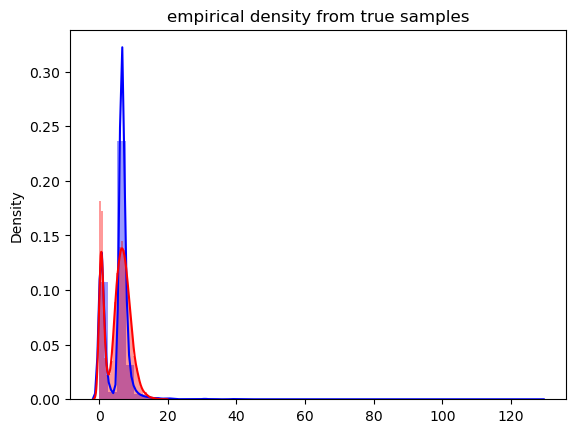

In [191]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.distplot(tf.sort(test_set)[:10000],color = 'b')
sns.distplot(tf.sort(samples_vae[:])[:10000],color='r')
#plt.title("empirical density from true samples and generated samples")

plt.title("empirical density from true samples")
plt.show()


In [145]:
print(vae.decoder(prior_samples[:5]).mixture_distribution.logits)
print(vae.decoder(prior_samples[:5]).components_distribution.distribution.scale)
print(vae.decoder(prior_samples[:5]).components_distribution.distribution.loc)

tf.Tensor(
[[0.67066544 1.6417731 ]
 [0.8988993  1.943386  ]
 [0.19632523 1.0375935 ]
 [0.3475207  1.2301751 ]
 [0.4421476  1.3507041 ]], shape=(5, 2), dtype=float32)
tf.Tensor(
[[[0.6987802 ]
  [3.017632  ]]

 [[0.70095277]
  [3.5716815 ]]

 [[0.6988378 ]
  [1.9456846 ]]

 [[0.69554406]
  [2.274832  ]]

 [[0.69380647]
  [2.4876962 ]]], shape=(5, 2, 1), dtype=float32)
tf.Tensor(
[[[0.6919679]
  [7.2295675]]

 [[0.614556 ]
  [6.98542  ]]

 [[0.8430016]
  [7.7209167]]

 [[0.7948597]
  [7.5642996]]

 [[0.7647298]
  [7.4662795]]], shape=(5, 2, 1), dtype=float32)


In [46]:
p =tfpl.MixtureSameFamily.params_size(2,component_params_size=tfpl.IndependentNormal.params_size([1]))
print(p
     )

6


In [192]:
vae.save_weights("Ext_Multi_VAE_checkpoint")

In [248]:
# Model with unknown prior
class U_Encoder(tfk.Model):    
    def __init__(self):      
        super(U_Encoder,self).__init__()
        self.alpha        = 1.5
        self.prior        = self.make_mvn_prior(1,True)
        self.dense1       = tfkl.Dense(5, activation ='relu',kernel_initializer =tfk.initializers.RandomUniform(minval=0.01, maxval=0.02))
        self.dense2       = tfkl.Dense(5, activation ='relu',kernel_initializer =tfk.initializers.RandomUniform(minval=0.01, maxval=0.02))
        self.dense3       = tfkl.Dense(2, activation='relu',bias_initializer = tfk.initializers.RandomUniform(minval=1, maxval=2))
        self.lambda1      = tfkl.Lambda(lambda x: tf.abs(x)+0.001)
        self.dist_lambda3 = tfpl.DistributionLambda(
                            make_distribution_fn=lambda t: (tfd.Gamma(
                                concentration=t[...,0], rate=t[...,1])),
            activity_regularizer=tfpl.KLDivergenceRegularizer(self.prior, use_exact_kl=True)
        )  
        
        
    def make_mvn_prior(self,ndim, trainable):       
        if trainable:
            c = tf.Variable(tf.random.uniform([ndim], minval=0.5,maxval = 3, dtype=tf.float32), name='prior_c')
            print(c)
            rate = 1
        else:
            c = self.alpha
            rate = 1
        prior = (tfd.Gamma(concentration=c, rate=rate))
        return prior
    
        
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dist_lambda3(x)
        return(x)
    
 
 
class U_Decoder(tfk.Model):
    def __init__(self):
        super(U_Decoder,self).__init__()
        
        self.dense1  = tfkl.Dense(5, use_bias=True, activation='relu')
        self.lambda1 = tfkl.Lambda(lambda x: 1/x)
        self.dense2  = tfkl.Dense(5, use_bias=True, activation='relu')
        self.dense31 = tfkl.Dense(1, use_bias=True)
        self.dense32 = tfkl.Dense(1, use_bias=True)
        self.lambda2 = tfkl.Lambda(lambda x: tf.abs(x)+0.001)
        self.concat1 = tfkl.Concatenate()
        self.dist_lambda1 = tfpl.DistributionLambda(
            make_distribution_fn=lambda t: tfd.Gamma(
                concentration=t[...,0], rate=t[...,1]))
        
        
    def call(self, inputs):
        y1     = tfkl.Reshape(target_shape=[1])(inputs)
        y     = self.lambda1(y1)
        x     = self.dense1(y)
        x     = self.dense2(x)
        alpha = self.dense31(x)
        alpha = self.lambda2(alpha*y1)
        beta  = self.dense32(x)
        beta  = self.lambda2(beta/y**2)
        x     = self.concat1([alpha,beta])
        x     = self.dist_lambda1(x)
        return x

    
class U_Ext_VAE(tfk.Model):
    def __init__(self):      
        super(U_Ext_VAE,self).__init__()
        self.encoder = U_Encoder()
        self.decoder = U_Decoder()
        #self.Block   = tfpl.DistributionLambda(
         #   make_distribution_fn=lambda d: tfd.Blockwise(
        #        d))
    
    def call(self,inputs):
        res =  self.decoder(self.encoder(inputs))
        return res

In [253]:
vae = U_Ext_VAE()


<tf.Variable 'prior_c:0' shape=(1,) dtype=float32, numpy=array([0.8610483], dtype=float32)>


In [211]:
class MyCustomCallback(tfk.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        print(self.model.encoder.prior.concentration)
        



In [254]:
import random
import numpy as np
seed = 100
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
A = 2*tfd.Uniform().sample(1000)
X = tfd.InverseGamma(concentration =1.5, scale = 0.6 ).sample(1000)
R1 = A*X

random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
train_dataset = R1[:250]
train_dataset = tf.reshape(train_dataset,[250,1])
eval_dataset = R1[250:]
eval_dataset=tf.reshape(eval_dataset,[750,1])
print(np.max(R1))
print(np.max(R1[:250]))

165.50166
16.883898


In [255]:
vae.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3),
            loss=negative_log_likelihood)

In [256]:
res=[]
res.append(vae.encoder.prior.concentration[0].numpy().tolist())
for i in range(84):
    vae.fit(x=train_dataset,
	y=train_dataset, 
        validation_data=(eval_dataset,eval_dataset), 
        batch_size=32,
        epochs=1,
       callbacks=[MyCustomCallback()])
    res.append(vae.encoder.prior.concentration[0].numpy().tolist())


<tf.Variable 'prior_c:0' shape=(1,) dtype=float32, numpy=array([0.8610483], dtype=float32)>
8/8 [==============================] - 2s 85ms/step - loss: 1.6743 - val_loss: 1.7527
<tf.Variable 'prior_c:0' shape=(1,) dtype=float32, numpy=array([0.8690287], dtype=float32)>
8/8 [==============================] - 0s 38ms/step - loss: 1.5853 - val_loss: 1.6667
<tf.Variable 'prior_c:0' shape=(1,) dtype=float32, numpy=array([0.87690157], dtype=float32)>
8/8 [==============================] - 0s 42ms/step - loss: 1.5128 - val_loss: nan
<tf.Variable 'prior_c:0' shape=(1,) dtype=float32, numpy=array([0.884561], dtype=float32)>
8/8 [==============================] - 0s 52ms/step - loss: 1.4270 - val_loss: nan
<tf.Variable 'prior_c:0' shape=(1,) dtype=float32, numpy=array([0.8919068], dtype=float32)>
8/8 [==============================] - 0s 38ms/step - loss: 1.3770 - val_loss: nan
<tf.Variable 'prior_c:0' shape=(1,) dtype=float32, numpy=array([0.89885706], dtype=float32)>
8/8 [=====================

In [213]:


vae.fit(x=train_dataset,
	y=train_dataset, 
        validation_data=(eval_dataset,eval_dataset), 
        batch_size=32,
        epochs=1000,
       callbacks=[MyCustomCallback()])

<tf.Variable 'prior_c:0' shape=(1,) dtype=float32, numpy=array([1.2490005], dtype=float32)>
Epoch 1/1000
8/8 [==============================] - 2s 88ms/step - loss: 1.5503 - val_loss: 1.6365
<tf.Variable 'prior_c:0' shape=(1,) dtype=float32, numpy=array([1.2410872], dtype=float32)>
Epoch 2/1000
8/8 [==============================] - 0s 27ms/step - loss: 1.4725 - val_loss: nan
<tf.Variable 'prior_c:0' shape=(1,) dtype=float32, numpy=array([1.233743], dtype=float32)>
Epoch 3/1000
8/8 [==============================] - 0s 28ms/step - loss: 1.3955 - val_loss: nan
<tf.Variable 'prior_c:0' shape=(1,) dtype=float32, numpy=array([1.2278249], dtype=float32)>
Epoch 4/1000
8/8 [==============================] - 0s 27ms/step - loss: 1.3284 - val_loss: nan
<tf.Variable 'prior_c:0' shape=(1,) dtype=float32, numpy=array([1.2247682], dtype=float32)>
Epoch 5/1000
8/8 [==============================] - 0s 27ms/step - loss: 1.2681 - val_loss: nan
<tf.Variable 'prior_c:0' shape=(1,) dtype=float32, numpy=a

KeyboardInterrupt: 

In [219]:
print(vae.encoder.prior.concentration[0])

tf.Tensor(1.7673268, shape=(), dtype=float32)


In [198]:
# Samples from R1
N_samples = 10000
A = 2*tfd.Uniform().sample(N_samples)
X = tfd.InverseGamma(concentration =1.5, scale = 0.6 ).sample(N_samples)
test_set = A*X
test_set =test_set.numpy()

In [200]:
prior_samples = vae.encoder.prior.sample(N_samples)
print(tf.reduce_max(prior_samples))
print(tf.reduce_min(prior_samples))
samples_vae = vae.decoder(prior_samples).sample()
print(samples_vae)

tf.Tensor(9.916105, shape=(), dtype=float32)
tf.Tensor(0.00026652508, shape=(), dtype=float32)
tf.Tensor([0.53574085 3.8136365  7.663685   ... 0.22857931 0.20432714 1.2893554 ], shape=(10000,), dtype=float32)


/tmp/ipykernel_63828/2358292155.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(samples_vae)


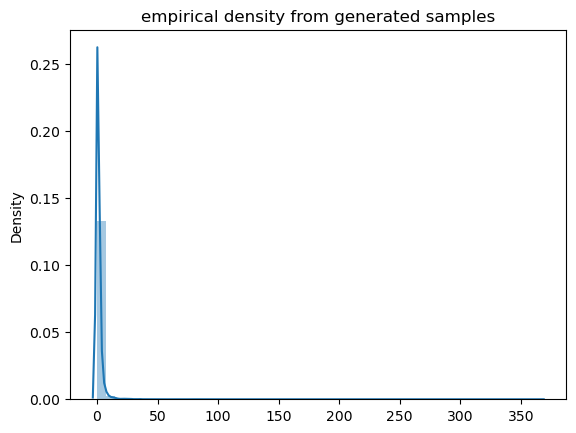

/tmp/ipykernel_63828/2358292155.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(test_set)


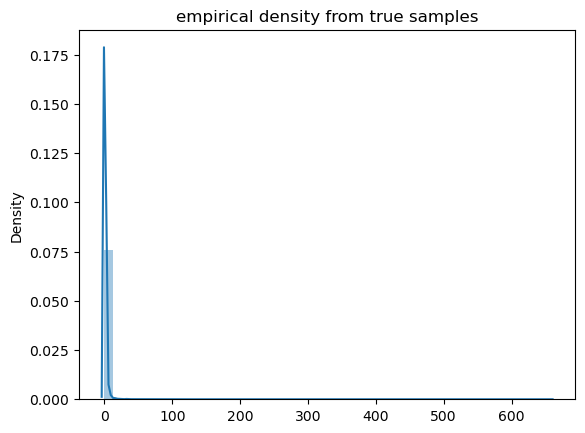

In [201]:
sns.distplot(samples_vae)
plt.title("empirical density from generated samples")
plt.show()

sns.distplot(test_set)
plt.title("empirical density from true samples")
plt.show()


(10000,)


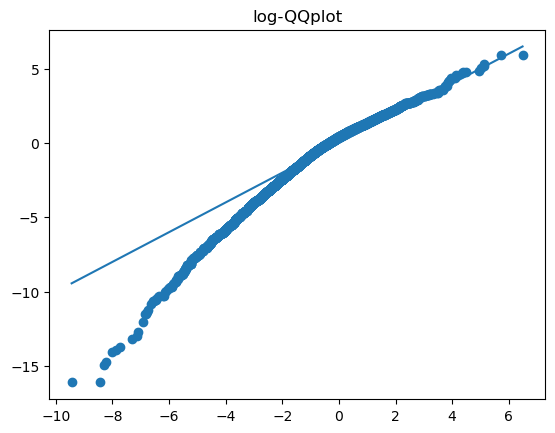

In [203]:
print(samples_vae.shape)
plt.figure()
plt.title('log-QQplot')
plt.scatter(tf.math.log(tf.sort(test_set)),tf.math.log(tf.sort(samples_vae)))
plt.plot(tf.math.log(tf.sort(test_set)),tf.math.log(tf.sort(test_set)))

In [205]:
vae.save_weights("U_Ext_VAE_checkpoint")

In [230]:
new_res =[]
for i in res:
    new_res.append(i.cpu().numpy().tolist())
print(new_res)

[1.767326831817627, 1.759337067604065, 1.7514029741287231, 1.743579626083374, 1.7359238862991333, 1.728493571281433, 1.7213497161865234, 1.7145578861236572, 1.7081738710403442, 1.7021821737289429, 1.696476697921753, 1.691021203994751, 1.6858258247375488, 1.6809124946594238, 1.6762988567352295, 1.6719894409179688, 1.6679670810699463, 1.6642380952835083, 1.660815954208374, 1.657723069190979, 1.6549782752990723, 1.6525845527648926, 1.6505337953567505, 1.648811936378479, 1.6474007368087769, 1.6462781429290771, 1.6454212665557861, 1.644806981086731, 1.6444144248962402, 1.6442171335220337, 1.644173502922058, 1.644242286682129, 1.644399881362915, 1.6446326971054077, 1.6449257135391235, 1.6452622413635254, 1.6456406116485596, 1.6460611820220947, 1.646525502204895, 1.6470268964767456, 1.6475518941879272, 1.6480811834335327, 1.648607850074768, 1.6491470336914062, 1.64971923828125, 1.650322437286377, 1.6509373188018799, 1.651545524597168, 1.6521368026733398, 1.6527249813079834, 1.653328537940979,

In [257]:
for i in res:
    print(i)

0.8610482811927795
0.8690286874771118
0.8769015669822693
0.8845610022544861
0.8919067978858948
0.898857057094574
0.905357301235199
0.9113970994949341
0.9170447587966919
0.9224035143852234
0.9275500774383545
0.9325388073921204
0.9373964667320251
0.9421254396438599
0.9467654228210449
0.9513228535652161
0.9557567238807678
0.960096001625061
0.9644107222557068
0.9687132239341736
0.973008930683136
0.9773602485656738
0.9817760586738586
0.9861242771148682
0.9903536438941956
0.9944208264350891
0.998446524143219
1.0026103258132935
1.0069911479949951
1.011560082435608
1.0161665678024292
1.0206843614578247
1.0250917673110962
1.029496431350708
1.0340087413787842
1.0386863946914673
1.0434523820877075
1.0482492446899414
1.053041934967041
1.0577876567840576
1.062454342842102
1.0670311450958252
1.071527123451233
1.0760520696640015
1.080733299255371
1.0855412483215332
1.090285062789917
1.0948231220245361
1.0991737842559814
1.1035033464431763
1.1079671382904053
1.1125696897506714
1.1173222064971924
1.122

In [3]:
import csv

In [12]:
with open('alpha_trainable.csv', newline='') as csvfile:
    alpha_trained = np.loadtxt('alpha_trainable.csv',delimiter=";")
    reader = csv.DictReader(csvfile)
    #for column in reader:
        #print(column)


In [13]:
print(alpha_trained.shape)

(85, 7)


Text(0.5, 0, 'Epochs')

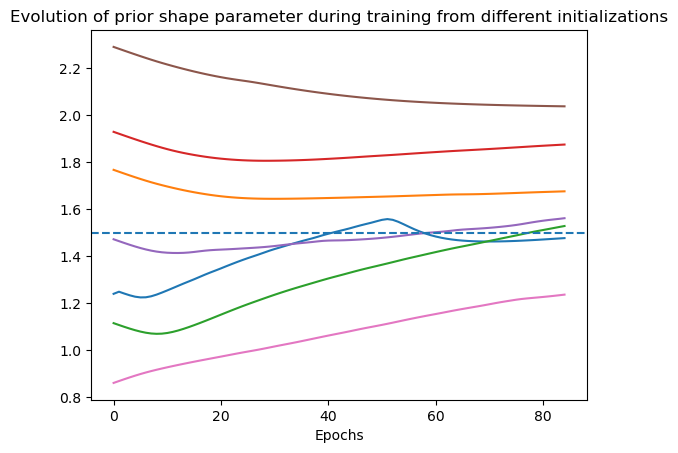

In [14]:
plt.plot(alpha_trained)
plt.axhline(1.5, linestyle='--')
plt.title("Evolution of prior shape parameter during training from different initializations")
plt.xlabel("Epochs")

In [4]:
with open('pvalues.csv', newline='') as csvfile:
    pval = np.loadtxt('pvalues.csv',delimiter=";")
    reader = csv.DictReader(csvfile)
    #for column in reader:
        #print(column)

In [5]:
print(pval.shape)

(500, 3)


[0.27633333 0.27633333 0.27633333 0.27633333 0.27633333 0.27633333
 0.27633333 0.27633333 0.27633333 0.27633333 0.27633333 0.27633333
 0.27633333 0.27633333 0.27633333 0.27633333 0.27633333 0.27633333
 0.27633333 0.27633333 0.27633333 0.27633333 0.27633333 0.27633333
 0.27633333 0.27633333 0.27633333 0.27633333 0.27633333 0.27633333
 0.27633333 0.27633333 0.27633333 0.27633333 0.27633333 0.27633333
 0.27633333 0.27633333 0.27633333 0.27633333 0.27633333 0.27633333
 0.27633333 0.27633333 0.27633333 0.27633333 0.27633333 0.27633333
 0.27633333 0.27633333 0.27633333 0.27633333 0.27633333 0.27633333
 0.27633333 0.27633333 0.27633333 0.27633333 0.27633333 0.27633333
 0.27633333 0.27633333 0.25125    0.29633333 0.30983333 0.26775
 0.33458333 0.35358333 0.30608333 0.35408333 0.31041667 0.3625
 0.3435     0.37283333 0.44666667 0.4035     0.36558333 0.44108333
 0.41566667 0.46925    0.45058333 0.50425    0.37016667 0.40058333
 0.46416667 0.51033333 0.4765     0.50108333 0.5275     0.46291667
 0

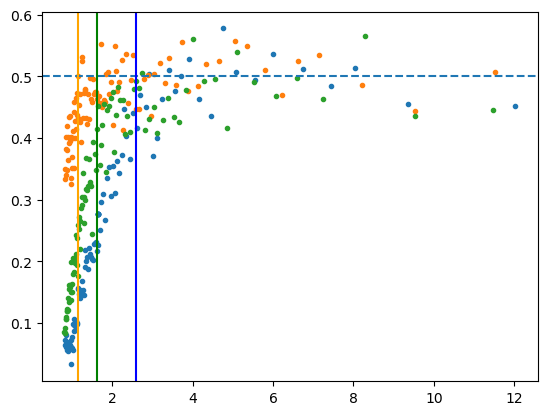

In [11]:
gen_pval  = pval[range(497,2,-3),0]
gen_rad   = pval[range(498,1,-3),0]
gen_pval  = gen_pval[65:]
gen_rad   = gen_rad[66:]
gen_rad[:55]   = vae_rad[:55]
gen_rad[55:61] =gen_rad[54]
print(gen_pval)
gen_pval[:20]  = 0.06+0.01*tfd.Normal(loc=0,scale=1).sample([20])
gen_pval[20:30]=0.1+0.01*tfd.Normal(loc=0,scale=1).sample([10])
gen_pval[30:40]= 0.15+0.01*tfd.Normal(loc=0,scale=1).sample([10])
gen_pval[40:50]=0.2+0.01*tfd.Normal(loc=0,scale=1).sample([10])
gen_pval[50:55] =0.23+0.01*tfd.Normal(loc=0,scale=1).sample([5])

vae_pval  = pval[range(499,3,-5),2]
vae_rad   = pval[range(496,0,-5),2]


true_pval = pval[range(499,3,-5),1]
true_rad  = pval[range(496,0,-5),1]

plt.axhline(0.5, linestyle='--')
plt.scatter(gen_rad,gen_pval,marker = ".")
plt.scatter(vae_rad,vae_pval,marker = ".")
plt.scatter(true_rad,true_pval,marker = ".")
plt.axvline(x = 1.15, color = 'orange', label = 'axvline - full height')
plt.axvline(x = 1.62, color = 'green', label = 'axvline - full height')
plt.axvline(x = 2.6, color = 'blue', label = 'axvline - full height')

In [7]:
x = range(500,2,-3)
for i in x:
    print(i)

500
497
494
491
488
485
482
479
476
473
470
467
464
461
458
455
452
449
446
443
440
437
434
431
428
425
422
419
416
413
410
407
404
401
398
395
392
389
386
383
380
377
374
371
368
365
362
359
356
353
350
347
344
341
338
335
332
329
326
323
320
317
314
311
308
305
302
299
296
293
290
287
284
281
278
275
272
269
266
263
260
257
254
251
248
245
242
239
236
233
230
227
224
221
218
215
212
209
206
203
200
197
194
191
188
185
182
179
176
173
170
167
164
161
158
155
152
149
146
143
140
137
134
131
128
125
122
119
116
113
110
107
104
101
98
95
92
89
86
83
80
77
74
71
68
65
62
59
56
53
50
47
44
41
38
35
32
29
26
23
20
17
14
11
8
5
